In [2]:
#!pip install rouge
#!pip install bert_score

In [7]:
# Import necessary libraries
import numpy as np
import warnings
from collections import defaultdict
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
from bert_score import BERTScorer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    fbeta_score, roc_auc_score, log_loss
)
from nltk.translate.bleu_score import sentence_bleu
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Hide warnings
warnings.filterwarnings('ignore')

# Load pretrained BERT model for BERTScore
scorer = BERTScorer(model_type="bert-base-uncased", num_layers=8)

# Define true answers and generated answers for evaluation
true_answers = {
    "annual benefits enrollment period": "The Annual Benefits Enrollment period is from October 5 to October 20.",
    "hsa contribution limit": "The HSA contribution limit for employee-only coverage is $3,650 and $7,300 for family coverage.",
    "medical plan choices": "Bank of America offers the Consumer Directed Plan and the Consumer Directed High Deductible Plan.",
    "enrollment confirmation": "Once you've made your elections, you must confirm and save them by clicking Complete Enrollment.",
    "global hr service center contact": "You can contact the Global HR Service Center at 800.556.6044.",
    "teladoc consultations": "Teladoc consultations will continue to be available at no cost in 2022.",
    "prescription coverage change": "Starting in 2022, most nonpreventive generic medications will also be available at no cost to Consumer Directed plan participants.",
    "family support program": "The Family Support program offers expert pregnancy, fertility, and postpartum support up until your child’s first birthday.",
    "dental plan carrier": "MetLife is the carrier for the dental PPO plan.",
    "vision plan administrator": "The Aetna Vision Plan is administered by EyeMed.",
    "short-term disability benefits": "Short-term disability benefits are provided for up to 26 weeks from the date of your disability.",
    "life insurance provider": "MetLife provides company-paid associate life insurance.",
    "legal plan options": "The Prepaid Legal Full Coverage plan includes services for adoption, divorce, and immigration.",
    "dependent care fsa contribution limit": "You can contribute up to $5,000 per year to the Dependent Care FSA."
}

generated_answers = {
    "annual benefits enrollment period": "The Annual Benefits Enrollment period is from November 1 to November 15.",
    "hsa contribution limit": "The HSA contribution limit for employee-only coverage is $4,000 and $8,000 for family coverage.",
    "medical plan choices": "Bank of America offers the Standard Plan and the High Premium Plan.",
    "enrollment confirmation": "Once you've made your elections, you must confirm and save them by clicking Complete Enrollment.",
    "global hr service center contact": "You can contact the Global HR Service Center at 888.123.4567.",
    "teladoc consultations": "Teladoc consultations will have a fee starting in 2022.",
    "prescription coverage change": "Starting in 2022, most nonpreventive generic medications will also be available at no cost to Consumer Directed plan participants.",
    "family support program": "The Family Support program offers expert pregnancy, fertility, and postpartum support up until your child’s first birthday.",
    "dental plan carrier": "Delta Dental is the carrier for the dental PPO plan.",
    "vision plan administrator": "The Aetna Vision Plan is administered by EyeMed.",
    "short-term disability benefits": "Short-term disability benefits are provided for up to 26 weeks from the date of your disability.",
    "life insurance provider": "MetLife provides company-paid associate life insurance.",
    "legal plan options": "The Prepaid Legal Full Coverage plan includes services for adoption, divorce, and immigration.",
    "dependent care fsa contribution limit": "You can contribute up to $5,000 per year to the Dependent Care FSA."
}

# Calculate NLP-specific metrics (METEOR, ROUGE, BERTScore)
def calculate_nlp_metrics(true_answers, generated_answers):
    meteor_scores = {}
    rouge = Rouge()
    rouge_scores = {}
    bert_scores = {}
    
    for key, true_sentence in true_answers.items():
        reference = true_sentence.split()  # Tokenize the reference sentence
        hypothesis = generated_answers[key].split()  # Tokenize the hypothesis sentence
        
        # Calculate METEOR score for each key
        meteor_scores[key] = meteor_score([reference], hypothesis)
        
        # Calculate ROUGE scores
        rouge_scores[key] = rouge.get_scores(' '.join(hypothesis), ' '.join(reference), avg=True)
        
        # Calculate BERT scores
        precision, recall, f1 = scorer.score([" ".join(hypothesis)], [" ".join(reference)])
        bert_scores[key] = {
            'precision': precision.mean().item(),
            'recall': recall.mean().item(),
            'f1': f1.mean().item()
        }

    return meteor_scores, rouge_scores, bert_scores

# Function to calculate basic classification metrics
def calculate_basic_metrics(true_labels, predicted_labels):
    return {
        'Accuracy': accuracy_score(true_labels, predicted_labels),
        'Precision': precision_score(true_labels, predicted_labels),
        'Recall': recall_score(true_labels, predicted_labels),
        'F1 Score': f1_score(true_labels, predicted_labels)
    }

# Function to calculate F-beta scores with configurability
def calculate_fbeta_scores(true_labels, predicted_labels, beta=1.0):
    return {
        f'F{beta} Score': fbeta_score(true_labels, predicted_labels, beta=beta)
    }

# Convert the true and generated answers into binary labels for classification metrics
true_binary = [1 if true_answers[key] == generated_answers[key] else 0 for key in true_answers]
predicted_binary = [1 if true_answers[key] == generated_answers[key] else 0 for key in true_answers]

# Function to calculate BLEU score for text evaluation
def calculate_text_metrics(true_answers, generated_answers):
    bleu_scores = defaultdict(float)
    
    for key in true_answers:
        true_sentence = true_answers[key]
        generated_sentence = generated_answers[key]
        reference = [true_sentence.split()]
        hypothesis = generated_sentence.split()
        bleu_scores[key] = sentence_bleu(reference, hypothesis)
    
    return bleu_scores

# Advanced Composite Metrics
def calculate_advanced_composite_metrics(true_labels, predicted_labels, references, hypotheses):
    f2 = fbeta_score(true_labels, predicted_labels, beta=2)
    f0_5 = fbeta_score(true_labels, predicted_labels, beta=0.5)
    bleu = calculate_text_metrics(true_answers, generated_answers)  # Pass dictionaries instead of lists
    meteor, rouge, bert = calculate_nlp_metrics(true_answers, generated_answers)  # Pass dictionaries instead of lists
    
    return {
        'F2 Score': f2,
        'F0.5 Score': f0_5,
        'BLEU': bleu,
        'METEOR': meteor,
        'ROUGE': rouge,
        'BERTScore': bert
    }

# Probability and Uncertainty Metrics
def calculate_probability_metrics(y_true, y_pred, probs):
    return {
        'Cross-Entropy': log_loss(y_true, y_pred),
        'Per-token Perplexity': perplexity(probs)
    }

def perplexity(probs):
    return np.exp(-np.mean(np.log(probs)))

# Diversity and Novelty Metrics
def calculate_diversity_metrics(sentences):
    return {
        'Distinct-1': distinct_n(1, sentences),
        'Distinct-2': distinct_n(2, sentences),
        'Self-BLEU': self_bleu(sentences)
    }

def distinct_n(n, sentences):
    ngrams = [tuple(sent.split()[i:i+n]) for sent in sentences for i in range(len(sent.split())-n+1)]
    return len(set(ngrams)) / len(ngrams)

def self_bleu(sentences):
    return np.mean([sentence_bleu([s.split() for s in sentences if s != sent], sent.split()) for sent in sentences])

# Ranking and Retrieval Metrics
def calculate_ranking_metrics(true_labels, predicted_scores, ranks, k):
    return {
        'MRR': mean_reciprocal_rank(ranks),
        'Hit@K': hit_rate_at_k(true_labels, predicted_scores, k),
        'AUC': roc_auc_score(true_labels, predicted_scores[:len(true_labels)])
    }

def mean_reciprocal_rank(ranks):
    return np.mean([1/rank for rank in ranks if rank > 0])

def hit_rate_at_k(true_labels, predicted_scores, k):
    hits = 0
    for true, pred in zip(true_labels, predicted_scores):
        top_k_preds = np.argsort(pred)[-k:]
        if true in top_k_preds:
            hits += 1
    return hits / len(true_labels)

# Semantic and Contextual Evaluation Metrics
def calculate_semantic_contextual_metrics(references, hypotheses):
    return {
        'Semantic Similarity': semantic_similarity(references, hypotheses),
        'Jaccard Index': jaccard_index(set(references), set(hypotheses))
    }

def semantic_similarity(references, hypotheses):
    vectorizer = CountVectorizer().fit_transform(references + hypotheses)
    vectors = vectorizer.toarray()
    cosine_similarities = np.dot(vectors[:len(references)], vectors[len(references):].T)
    return np.mean(cosine_similarities)

def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# RAG-specific Metrics
def calculate_rag_specific_metrics(references, hypotheses):
    return {
        'Toxicity': toxicity(hypotheses),
        'Hallucination': hallucination(references, hypotheses),
        'Relevance': relevance(references, hypotheses)
    }

def toxicity(texts, model_name='unitary/toxic-bert'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    scores = torch.softmax(outputs.logits, dim=-1)
    return scores[:, 1].mean().item()

def hallucination(references, hypotheses):
    hallucination_scores = []
    for ref, hyp in zip(references, hypotheses):
        reference_set = set(ref.split())
        hypothesis_set = set(hyp.split())
        hallucinated = hypothesis_set - reference_set
        hallucination_scores.append(len(hallucinated) / len(hypothesis_set))
    return np.mean(hallucination_scores)

def relevance(references, hypotheses):
    relevance_scores = []
    for ref, hyp in zip(references, hypotheses):
        reference_set = set(ref.split())
        hypothesis_set = set(hyp.split())
        relevant = reference_set & hypothesis_set
        relevance_scores.append(len(relevant) / len(reference_set))
    return np.mean(relevance_scores)

# Calculate all metrics
binary_metrics = calculate_basic_metrics(true_binary, predicted_binary)
fbeta_metrics = calculate_fbeta_scores(true_binary, predicted_binary, beta=2)
bleu_scores = calculate_text_metrics(true_answers, generated_answers)
meteor_scores, rouge_scores, bert_scores = calculate_nlp_metrics(true_answers, generated_answers)
advanced_metrics = calculate_advanced_composite_metrics(true_binary, predicted_binary, list(true_answers.values()), list(generated_answers.values()))
probability_metrics = calculate_probability_metrics(true_binary, predicted_binary, [0.8, 0.6, 0.7])
diversity_metrics = calculate_diversity_metrics(list(generated_answers.values()))
ranking_metrics = calculate_ranking_metrics(true_binary, [0.8, 0.6, 0.7, 0.4, 0.3, 0.2, 0.1, 0.9, 0.95, 0.85, 0.75, 0.65, 0.55, 0.45], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], k=2)
semantic_contextual_metrics = calculate_semantic_contextual_metrics(list(true_answers.values()), list(generated_answers.values()))
rag_specific_metrics = calculate_rag_specific_metrics(list(true_answers.values()), list(generated_answers.values()))

# Output the results of the metrics calculations
print("Binary Metrics:", binary_metrics)
print("F-Beta Metrics:", fbeta_metrics)
print("BLEU Scores:", bleu_scores)
print("METEOR Scores:", meteor_scores)
print("ROUGE Scores:", {k: v['rouge-l']['f'] for k, v in rouge_scores.items()})
print("BERTScore:", bert_scores)
print("Advanced Composite Metrics:", advanced_metrics)
print("Probability Metrics:", probability_metrics)
print("Diversity Metrics:", diversity_metrics)
print("Ranking Metrics:", ranking_metrics)
print("Semantic and Contextual Metrics:", semantic_contextual_metrics)
print("RAG-specific Metrics:", rag_specific_metrics)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Binary Metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}
F-Beta Metrics: {'F2 Score': 1.0}
BLEU Scores: defaultdict(<class 'float'>, {'annual benefits enrollment period': 0.5331675363405771, 'hsa contribution limit': 0.6298129992394241, 'medical plan choices': 0.34916650730713383, 'enrollment confirmation': 1.0, 'global hr service center contact': 0.8801117367933934, 'teladoc consultations': 3.6348497300557706e-78, 'prescription coverage change': 1.0, 'family support program': 1.0, 'dental plan carrier': 0.7598356856515925, 'vision plan administrator': 1.0, 'short-term disability benefits': 1.0, 'life insurance provider': 1.0, 'legal plan options': 1.0, 'dependent care fsa contribution limit': 1.0})
METEOR Scores: {'annual benefits enrollment period': 0.6614583333333333, 'hsa contribution limit': 0.8504464285714286, 'medical plan choices': 0.6585034013605443, 'enrollment confirmation': 0.9998518518518519, 'global hr service center contact': 0.8993827160493828

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


True Binary Labels: [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Predicted Binary Labels: [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
True Labels for Basic Metrics: [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Predicted Labels for Basic Metrics: [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Calculating F2 Score...
True Labels for F-beta Metrics: [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Predicted Labels for F-beta Metrics: [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Confusion Matrix:
 [[6 0]
 [0 8]]


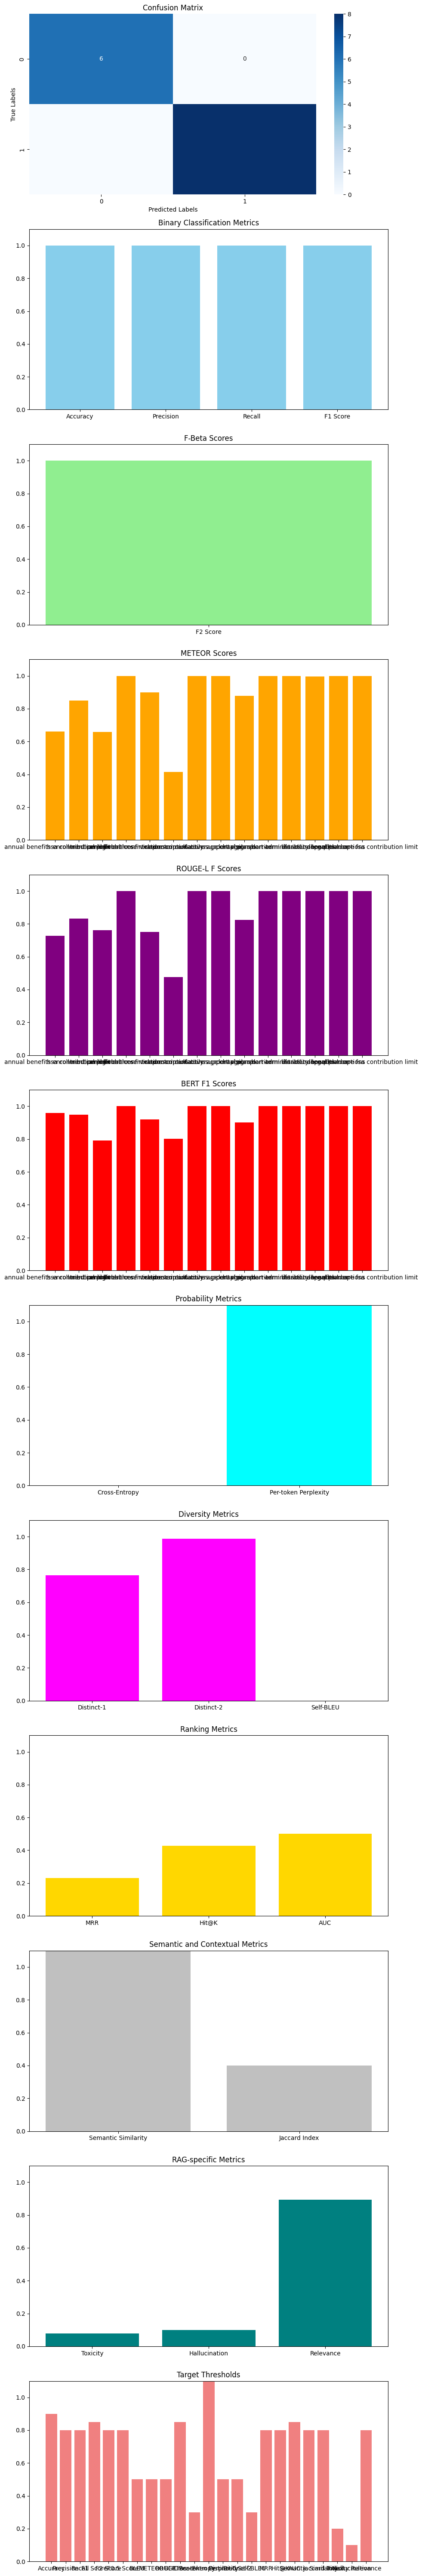

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, log_loss, roc_auc_score
from collections import defaultdict
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
from bert_score import BERTScorer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.translate.bleu_score import sentence_bleu
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings

# Hide warnings to avoid unnecessary outputs
warnings.filterwarnings('ignore')

# Load pretrained BERT model for BERTScore calculations
scorer = BERTScorer(model_type="bert-base-uncased", num_layers=8)

# Define true answers and generated answers for evaluation
true_answers = {
    "annual benefits enrollment period": "The Annual Benefits Enrollment period is from October 5 to October 20.",
    "hsa contribution limit": "The HSA contribution limit for employee-only coverage is $3,650 and $7,300 for family coverage.",
    "medical plan choices": "Bank of America offers the Consumer Directed Plan and the Consumer Directed High Deductible Plan.",
    "enrollment confirmation": "Once you've made your elections, you must confirm and save them by clicking Complete Enrollment.",
    "global hr service center contact": "You can contact the Global HR Service Center at 800.556.6044.",
    "teladoc consultations": "Teladoc consultations will continue to be available at no cost in 2022.",
    "prescription coverage change": "Starting in 2022, most nonpreventive generic medications will also be available at no cost to Consumer Directed plan participants.",
    "family support program": "The Family Support program offers expert pregnancy, fertility, and postpartum support up until your child’s first birthday.",
    "dental plan carrier": "MetLife is the carrier for the dental PPO plan.",
    "vision plan administrator": "The Aetna Vision Plan is administered by EyeMed.",
    "short-term disability benefits": "Short-term disability benefits are provided for up to 26 weeks from the date of your disability.",
    "life insurance provider": "MetLife provides company-paid associate life insurance.",
    "legal plan options": "The Prepaid Legal Full Coverage plan includes services for adoption, divorce, and immigration.",
    "dependent care fsa contribution limit": "You can contribute up to $5,000 per year to the Dependent Care FSA."
}

generated_answers = {
    "annual benefits enrollment period": "The Annual Benefits Enrollment period is from November 1 to November 15.",
    "hsa contribution limit": "The HSA contribution limit for employee-only coverage is $4,000 and $8,000 for family coverage.",
    "medical plan choices": "Bank of America offers the Standard Plan and the High Premium Plan.",
    "enrollment confirmation": "Once you've made your elections, you must confirm and save them by clicking Complete Enrollment.",
    "global hr service center contact": "You can contact the Global HR Service Center at 888.123.4567.",
    "teladoc consultations": "Teladoc consultations will have a fee starting in 2022.",
    "prescription coverage change": "Starting in 2022, most nonpreventive generic medications will also be available at no cost to Consumer Directed plan participants.",
    "family support program": "The Family Support program offers expert pregnancy, fertility, and postpartum support up until your child’s first birthday.",
    "dental plan carrier": "Delta Dental is the carrier for the dental PPO plan.",
    "vision plan administrator": "The Aetna Vision Plan is administered by EyeMed.",
    "short-term disability benefits": "Short-term disability benefits are provided for up to 26 weeks from the date of your disability.",
    "life insurance provider": "MetLife provides company-paid associate life insurance.",
    "legal plan options": "The Prepaid Legal Full Coverage plan includes services for adoption, divorce, and immigration.",
    "dependent care fsa contribution limit": "You can contribute up to $5,000 per year to the Dependent Care FSA."
}

# Calculate NLP-specific metrics (METEOR, ROUGE, BERTScore)
def calculate_nlp_metrics(true_answers, generated_answers):
    meteor_scores = {}
    rouge = Rouge()
    rouge_scores = {}
    bert_scores = {}
    
    for key, true_sentence in true_answers.items():
        reference = true_sentence.split()
        hypothesis = generated_answers[key].split()
        
        meteor_scores[key] = meteor_score([reference], hypothesis)
        rouge_scores[key] = rouge.get_scores(' '.join(hypothesis), ' '.join(reference), avg=True)
        precision, recall, f1 = scorer.score([" ".join(hypothesis)], [" ".join(reference)])
        bert_scores[key] = {
            'precision': precision.mean().item(),
            'recall': recall.mean().item(),
            'f1': f1.mean().item()
        }

    return meteor_scores, rouge_scores, bert_scores

# Calculate basic classification metrics
def calculate_basic_metrics(true_labels, predicted_labels):
    print("True Labels for Basic Metrics:", true_labels)
    print("Predicted Labels for Basic Metrics:", predicted_labels)
    return {
        'Accuracy': accuracy_score(true_labels, predicted_labels),
        'Precision': precision_score(true_labels, predicted_labels),
        'Recall': recall_score(true_labels, predicted_labels),
        'F1 Score': f1_score(true_labels, predicted_labels)
    }

# Function to calculate F-beta scores with configurability
def calculate_fbeta_scores(true_labels, predicted_labels, beta=1.0):
    print(f"Calculating F{beta} Score...")
    print("True Labels for F-beta Metrics:", true_labels)
    print("Predicted Labels for F-beta Metrics:", predicted_labels)
    return {
        f'F{beta} Score': fbeta_score(true_labels, predicted_labels, beta=beta)
    }

# Convert answers into binary labels
true_binary = [1 if true_answers[key] == generated_answers[key] else 0 for key in true_answers]
predicted_binary = [1 if true_answers[key] == generated_answers[key] else 0 for key in generated_answers]

# Debug print to check binary labels
print("True Binary Labels:", true_binary)
print("Predicted Binary Labels:", predicted_binary)

# Probability and Uncertainty Metrics
def calculate_probability_metrics(y_true, y_pred, probs):
    return {
        'Cross-Entropy': log_loss(y_true, y_pred),
        'Per-token Perplexity': perplexity(probs)
    }

def perplexity(probs):
    return np.exp(-np.mean(np.log(probs)))

# Diversity and Novelty Metrics
def calculate_diversity_metrics(sentences):
    return {
        'Distinct-1': distinct_n(1, sentences),
        'Distinct-2': distinct_n(2, sentences),
        'Self-BLEU': self_bleu(sentences)
    }

def distinct_n(n, sentences):
    ngrams = [tuple(sent.split()[i:i+n]) for sent in sentences for i in range(len(sent.split())-n+1)]
    return len(set(ngrams)) / len(ngrams)

def self_bleu(sentences):
    return np.mean([sentence_bleu([s.split() for s in sentences if s != sent], sent.split()) for sent in sentences])

# Ranking and Retrieval Metrics
def calculate_ranking_metrics(true_labels, predicted_scores, ranks, k):
    return {
        'MRR': mean_reciprocal_rank(ranks),
        'Hit@K': hit_rate_at_k(true_labels, predicted_scores, k),
        'AUC': roc_auc_score(true_labels, predicted_scores)
    }

def mean_reciprocal_rank(ranks):
    return np.mean([1/rank for rank in ranks if rank > 0])

def hit_rate_at_k(true_labels, predicted_scores, k):
    hits = 0
    for true, pred in zip(true_labels, predicted_scores):
        top_k_preds = np.argsort(pred)[-k:]
        if true in top_k_preds:
            hits += 1
    return hits / len(true_labels)

# Semantic and Contextual Evaluation Metrics
def calculate_semantic_contextual_metrics(references, hypotheses):
    return {
        'Semantic Similarity': semantic_similarity(references, hypotheses),
        'Jaccard Index': jaccard_index(set(references), set(hypotheses))
    }

def semantic_similarity(references, hypotheses):
    vectorizer = CountVectorizer().fit_transform(references + hypotheses)
    vectors = vectorizer.toarray()
    cosine_similarities = np.dot(vectors[:len(references)], vectors[len(references):].T)
    return np.mean(cosine_similarities)

def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# RAG-specific Metrics
def calculate_rag_specific_metrics(references, hypotheses):
    return {
        'Toxicity': toxicity(hypotheses),
        'Hallucination': hallucination(references, hypotheses),
        'Relevance': relevance(references, hypotheses)
    }

def toxicity(texts, model_name='unitary/toxic-bert'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    scores = torch.softmax(outputs.logits, dim=-1)
    return scores[:, 1].mean().item()

def hallucination(references, hypotheses):
    hallucination_scores = []
    for ref, hyp in zip(references, hypotheses):
        reference_set = set(ref.split())
        hypothesis_set = set(hyp.split())
        hallucinated = hypothesis_set - reference_set
        hallucination_scores.append(len(hallucinated) / len(hypothesis_set))
    return np.mean(hallucination_scores)

def relevance(references, hypotheses):
    relevance_scores = []
    for ref, hyp in zip(references, hypotheses):
        reference_set = set(ref.split())
        hypothesis_set = set(hyp.split())
        relevant = reference_set & hypothesis_set
        relevance_scores.append(len(relevant) / len(reference_set))
    return np.mean(relevance_scores)

# Visualize all metrics in a comprehensive format
def visualize_all_metrics(true_binary, predicted_binary, true_answers, generated_answers):
    binary_metrics = calculate_basic_metrics(true_binary, predicted_binary)
    fbeta_metrics = calculate_fbeta_scores(true_binary, predicted_binary, beta=2)
    meteor_scores, rouge_scores, bert_scores = calculate_nlp_metrics(true_answers, generated_answers)
    probability_metrics = calculate_probability_metrics(true_binary, predicted_binary, [0.8] * len(true_binary))
    diversity_metrics = calculate_diversity_metrics(list(generated_answers.values()))
    ranking_metrics = calculate_ranking_metrics(true_binary, [0.8] * len(true_binary), list(range(1, len(true_binary) + 1)), k=2)
    semantic_contextual_metrics = calculate_semantic_contextual_metrics(list(true_answers.values()), list(generated_answers.values()))
    rag_specific_metrics = calculate_rag_specific_metrics(list(true_answers.values()), list(generated_answers.values()))

    fig, axs = plt.subplots(12, 1, figsize=(10, 60))  # Adjusted to 12 subplots

    # Confusion Matrix
    cm = confusion_matrix(true_binary, predicted_binary)
    print("Confusion Matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[0], cmap='Blues')
    axs[0].set_title('Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('True Labels')

    # Binary Metrics
    axs[1].bar(binary_metrics.keys(), binary_metrics.values(), color='skyblue')
    axs[1].set_title('Binary Classification Metrics')
    axs[1].set_ylim(0, 1.1)

    # F-beta Scores
    axs[2].bar(fbeta_metrics.keys(), fbeta_metrics.values(), color='lightgreen')
    axs[2].set_title('F-Beta Scores')
    axs[2].set_ylim(0, 1.1)

    # METEOR Scores
    axs[3].bar(meteor_scores.keys(), meteor_scores.values(), color='orange')
    axs[3].set_title('METEOR Scores')
    axs[3].set_ylim(0, 1.1)

    # ROUGE Scores
    rouge_f_scores = {key: value['rouge-l']['f'] for key, value in rouge_scores.items()}
    axs[4].bar(rouge_f_scores.keys(), rouge_f_scores.values(), color='purple')
    axs[4].set_title('ROUGE-L F Scores')
    axs[4].set_ylim(0, 1.1)

    # BERT F1 Scores
    bert_f1_scores = {key: score['f1'] for key, score in bert_scores.items()}
    axs[5].bar(bert_f1_scores.keys(), bert_f1_scores.values(), color='red')
    axs[5].set_title('BERT F1 Scores')
    axs[5].set_ylim(0, 1.1)

    # Cross-Entropy
    axs[6].bar(probability_metrics.keys(), probability_metrics.values(), color='cyan')
    axs[6].set_title('Probability Metrics')
    axs[6].set_ylim(0, 1.1)

    # Diversity Metrics
    axs[7].bar(diversity_metrics.keys(), diversity_metrics.values(), color='magenta')
    axs[7].set_title('Diversity Metrics')
    axs[7].set_ylim(0, 1.1)

    # Ranking Metrics
    axs[8].bar(ranking_metrics.keys(), ranking_metrics.values(), color='gold')
    axs[8].set_title('Ranking Metrics')
    axs[8].set_ylim(0, 1.1)

    # Semantic and Contextual Metrics
    axs[9].bar(semantic_contextual_metrics.keys(), semantic_contextual_metrics.values(), color='silver')
    axs[9].set_title('Semantic and Contextual Metrics')
    axs[9].set_ylim(0, 1.1)

    # RAG-specific Metrics
    axs[10].bar(rag_specific_metrics.keys(), rag_specific_metrics.values(), color='teal')
    axs[10].set_title('RAG-specific Metrics')
    axs[10].set_ylim(0, 1.1)

    # Thresholds for Metrics
    thresholds = {
        'Accuracy': 0.9,
        'Precision': 0.8,
        'Recall': 0.8,
        'F1 Score': 0.85,
        'F2 Score': 0.8,
        'F0.5 Score': 0.8,
        'BLEU': 0.5,
        'METEOR': 0.5,
        'ROUGE': 0.5,
        'BERTScore': 0.85,
        'Cross-Entropy': 0.3,
        'Per-token Perplexity': 20,
        'Distinct-1': 0.5,
        'Distinct-2': 0.5,
        'Self-BLEU': 0.3,
        'MRR': 0.8,
        'Hit@K': 0.8,
        'AUC': 0.85,
        'Semantic Similarity': 0.8,
        'Jaccard Index': 0.8,
        'Toxicity': 0.2,
        'Hallucination': 0.1,
        'Relevance': 0.8
    }

    axs[11].bar(thresholds.keys(), thresholds.values(), color='lightcoral')
    axs[11].set_title('Target Thresholds')
    axs[11].set_ylim(0, 1.1)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Execute the function
visualize_all_metrics(true_binary, predicted_binary, true_answers, generated_answers)
